# NSF Computer and Information Science and Engineering (CISE) 

- `05050000`: Division of Computer and Network Systems (CNS)
- `05010000`: Division of Computing and Communication Foundations (CCF)
- `05020000`: Division of Information and Intelligent Systems (IIS)
- `05090000`: Office of Advanced Cyberinfrastructure (OAC)

In [14]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [15]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "05050000": "Division of Computer and Network Systems (CNS)",
    "05010000": "Division of Computing and Communication Foundations (CCF)",
    "05020000": "Division of Information and Intelligent Systems (IIS)",
    "05090000": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [16]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [18]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 405
Division of Computing and Communication Foundations (CCF) 332
Division of Information and Intelligent Systems (IIS) 362
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 633, 2: 243, 3: 123, 5: 83, 4: 61, 6: 4, 0: 2, 7: 2, 8: 1})


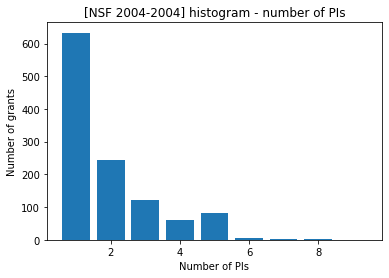

In [19]:
histogram_num_pis(data, years, div_type.keys())

In [20]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0401049', '0403020', '0403130', '0403590', '0404001', '0404193', '0404297', '0404440', '0406305', '0406345', '0406384', '0410203', '0410246', '0410409', '0410524', '0410553', '0410771', '0410790', '0410918', '0410937', '0411127', '0411152', '0411307', '0412029', '0412858', '0412884', '0412894', '0412930', '0412965', '0413012', '0413078', '0413085', '0413138', '0413196', '0413214', '0413227', '0413251', '0413284', '0413321', '0413328', '0413709', '0414380', '0414409', '0414482', '0414557', '0414567', '0414630', '0414710', '0414762', '0414763', '0414791', '0414815', '0414976', '0414981', '0415016', '0415021', '0415101', '0415175', '0415195', '0415257', '0415865', '0415923', '0416364', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423039', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426557', '0426627', '0426674', '0426879', '0426904', '0427260', '0427385', '0427695', '0428427', '0429154', '0429211'

In [8]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

243 grants with 2 PIs


In [86]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0404297 union=2, max_group=2, numpub=3 6 5
0410203 union=2, max_group=2, numpub=6 6 1
0410246 union=2, max_group=2, numpub=13 16 4
0410409 union=1, max_group=1, numpub=2 2 0
0410553 union=2, max_group=2, numpub=7 8 3
0410771 union=2, max_group=2, numpub=9 15 9
0410918 union=2, max_group=2, numpub=8 18 12
0410937 union=2, max_group=2, numpub=19 20 7
0411127 union=2, max_group=2, numpub=1 41 41
0411152 union=0, max_group=0, numpub=1 1 0
0411307 union=2, max_group=2, numpub=6 33 29
0412029 union=1, max_group=1, numpub=1 1 0
0412884 union=1, max_group=1, numpub=8 8 0
0412894 union=1, max_group=1, numpub=7 7 0
0412930 union=2, max_group=2, numpub=12 12 1
0413012 union=2, max_group=2, numpub=2 5 4
0413078 union=1, max_group=1, numpub=3 3 0
0413085 union=2, max_group=2, numpub=4 16 15
0413138 union=2, max_group=2, numpub=10 10 1
0413196 union=1, max_group=1, numpub=23 23 0
0413214 union=2, max_group=1, numpub=16 16 0
0413227 union=2, max_group=2, numpub=4 13 12
0413251 union=2, max_group=2, n

In [101]:
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
    if len(G.edges) == 0:
        continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["date"], ts, te, data)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    ctypes.append("{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0))

print(len(ctypes), "grants - two PIs collaborated")
print(Counter(ctypes))

86 grants - two PIs collaborated
Counter({'111': 38, '010': 20, '110': 14, '011': 14})


In [102]:
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in two_separate+only_one_pi+no_publications:
    _,ts,te,G = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["date"], ts, te, data)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    ctypes.append("{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0))

print(len(ctypes), "grants - two_separate + only_one_pi + no_publications")
print(Counter(ctypes))

151 grants - two_separate + only_one_pi + no_publications
Counter({'000': 151})


In [88]:
set(dict_timestamps.keys())-set(two_cowork)

{'0429631'}

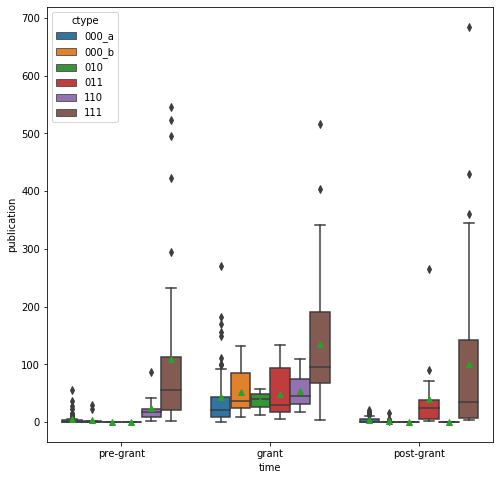

In [54]:
x = ["pre-grant", "grant", "post-grant"]
ctype = ['000_a', '000_b', '010', '011', '110', '111']
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "period": [dict_periods[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

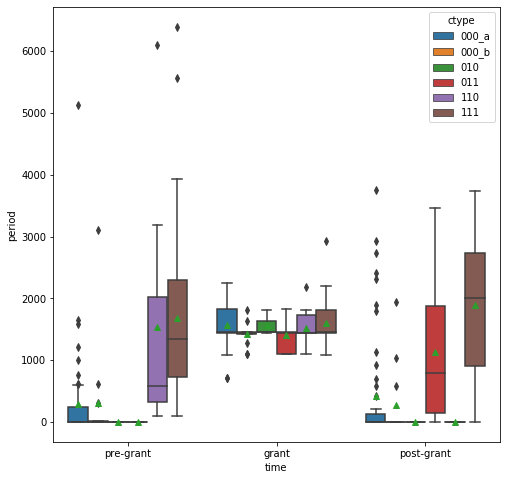

In [55]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


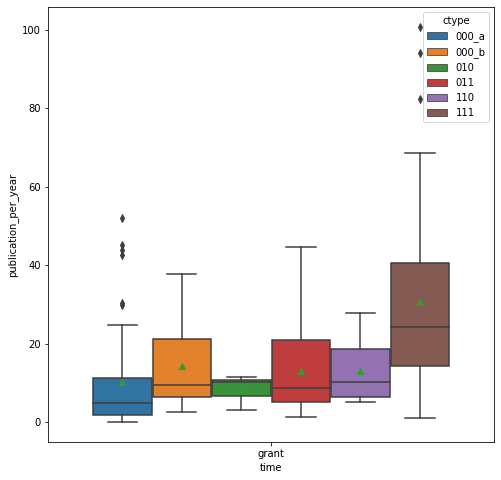

In [56]:
temp_data = box_plot_data[box_plot_data.time=="grant"]
temp_data["publication_per_year"] = temp_data["publication"]/temp_data["period"]*365
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication_per_year", hue="ctype", data=temp_data, showmeans=True, hue_order=ctype)


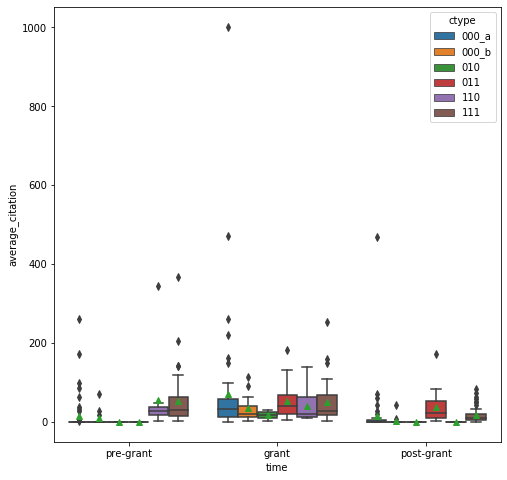

In [57]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

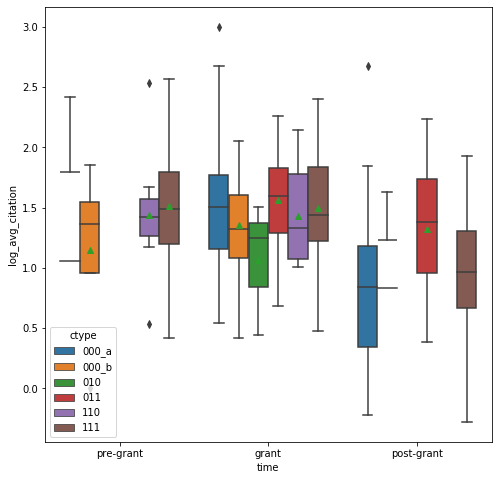

In [58]:
np.seterr(divide = 'ignore') 
box_plot_data["log_avg_citation"] = np.log10(box_plot_data["citation"]/box_plot_data["publication"])
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_avg_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

In [59]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


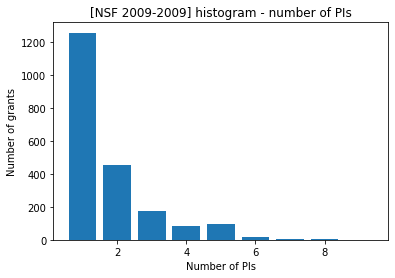

In [60]:
histogram_num_pis(data, years, div_type.keys())

In [61]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs


In [62]:
no_publications = []
collab_type = {}
dict_publications = {}
dict_citations = {}
dict_periods = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G_all.edges) == 0:
        no_publications.append(grant_id)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    acting_authors = []
    G = G_all.subgraph(pis)
    if len(G.edges) == 0:
        collab_type[grant_id] = "000"
        
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G_all.edges.data()]
    periods = {"pre-grant":max(0, (ts-min(dates)).days), "grant":(te-ts).days, "post-grant":max(0, (max(dates)-te).days)}
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        for u,v,data in G_all.edges.data():
            acting_authors.extend([u, v])
            if nxtype == "pre-grant":
                publications[nxtype] += 1 if convert_t(data["date"]) < ts else 0
                citations[nxtype] += data["citation"] if convert_t(data["date"]) < ts else 0
            if nxtype == "grant":
                publications[nxtype] += 1 if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0
                citations[nxtype] += data["citation"] if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0
            if nxtype == "post-grant":
                publications[nxtype] += 1 if te < convert_t(data["date"]) else 0
                citations[nxtype] += data["citation"] if te < convert_t(data["date"]) else 0
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_periods[grant_id] = periods
    
    if grant_id in collab_type and collab_type[grant_id] == "000":
#         print(grant_id, set(acting_authors).intersection(set(pis)))
        acting_pis = len(set(acting_authors).intersection(set(pis)))
        if acting_pis == 1: collab_type[grant_id] = "000_a"
        if acting_pis == 2: collab_type[grant_id] = "000_b"
        if acting_pis == 0: collab_type[grant_id] = "000_c"    
    else:
        collab_type[grant_id] = "{}{}{}".format(1 if publications["pre-grant"] > 0 else 0, 1 if publications["grant"] > 0 else 0, 1 if publications["post-grant"] > 0 else 0)
#     print(grant_id, collab_type[grant_id], publications.values(), periods.values(), citations.values())
    

In [63]:
Counter(collab_type.values())

Counter({'000_a': 105,
         '011': 34,
         '110': 26,
         '111': 110,
         '010': 10,
         '000_b': 40,
         '000_c': 10,
         '100': 1})

In [64]:
print("total {} grant with 2PIs - no publication: {}".format(len(grant_list), len(no_publications)))

total 457 grant with 2PIs - no publication: 121


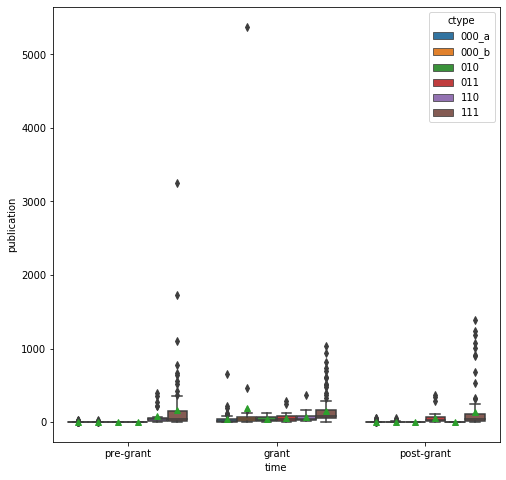

In [65]:
x = ["pre-grant", "grant", "post-grant"]
ctype = ['000_a', '000_b', '010', '011', '110', '111']
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "period": [dict_periods[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-pa

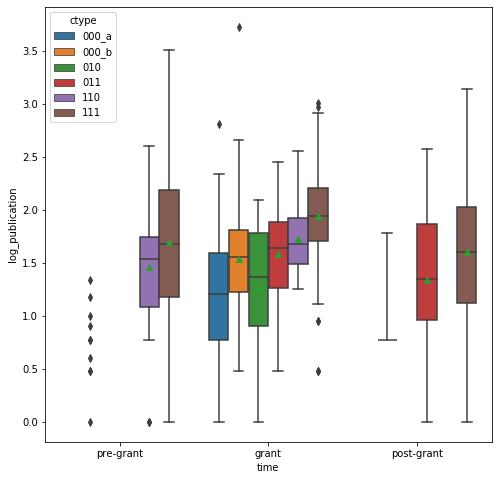

In [66]:
np.seterr(divide = 'ignore') 
box_plot_data["log_publication"] = np.log10(box_plot_data["publication"])
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

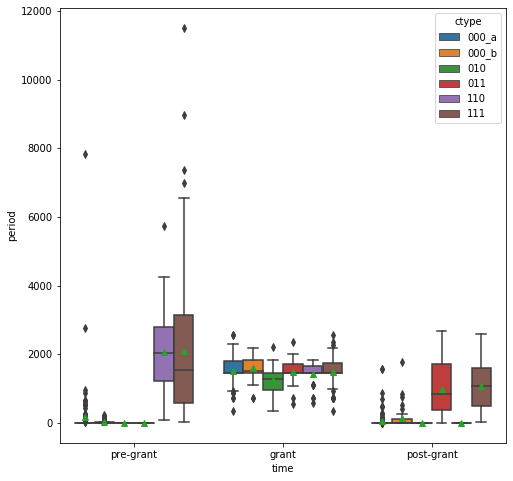

In [67]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-pa

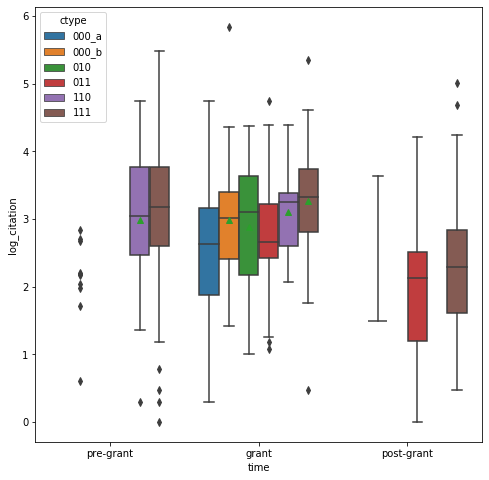

In [73]:
box_plot_data["log_citation"] = np.log10(box_plot_data["citation"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

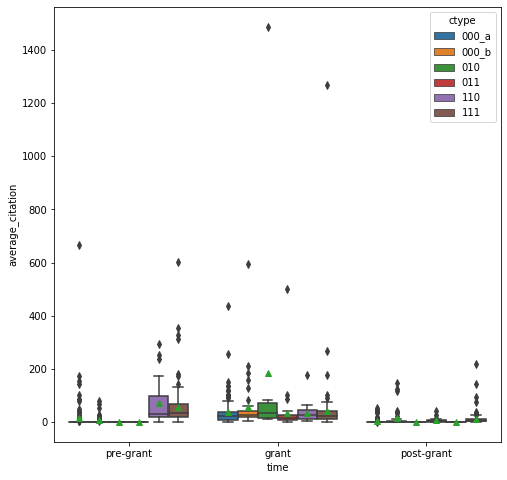

In [70]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

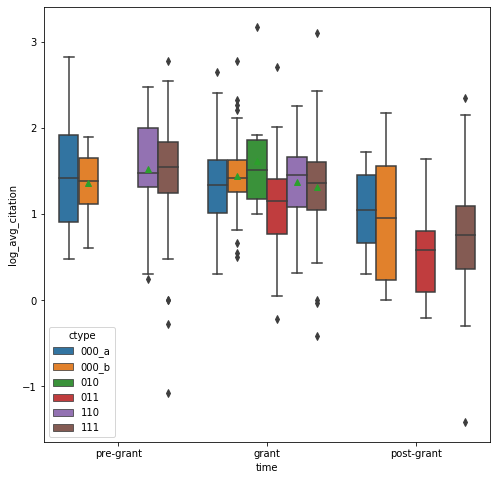

In [71]:
np.seterr(divide = 'ignore') 
box_plot_data["log_avg_citation"] = np.log10(box_plot_data["citation"]/box_plot_data["publication"])
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_avg_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)